### 支持向量機(SVM)
SVM 屬於機器學習中的Supervised learning其中一種方法

透過找出一個超平面，使之將兩個不同的集合分開

SVM 可分為以下兩種:
1. 線性可分支持向量機
2. 非線性可分支持向量機

### 線性可分支持向量機
1. 其目標是在特徵空間中找到一個分離超平面，能將例項分到不同的類
2. 離兩條虛線距離最近的點，就稱為"支持向量" (support vector)

![image.png](./img/%E7%B7%9A%E6%80%A7%E5%8F%AF%E5%88%86%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%A9%9F.jpg)


### 非線性可分支持向量機
1. Kernel trick 只是將資料投到更高維度的空間
2. 在高維度的空間進行高維度的分類或降維
兩個非線性的Kernel:
1. Polynomial 高次方轉換
2. Radial Basis Function 高斯轉換

![image.jpg](./img/%E9%9D%9E%E7%B7%9A%E6%80%A7%E5%8F%AF%E5%88%86%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%A9%9F.jpg)

In [1]:
import pandas as pd             #進行資料處理函式庫
import numpy as np              #高階大量的維度陣列與矩陣計算
import matplotlib.pyplot as plt #繪圖
import seaborn as sns           #繪圖
import io                       #負責處理資料 input/output
import requests                 #HTTP Request下載訓練資料用

### 一)載入資料集

In [2]:
url = "https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv"
s = requests.get(url).content
df_train = pd.read_csv(io.StringIO(s.decode("utf-8")))
#df_train = df_train.drop(labels=["sepal.length"],axis=1)    #移除sepal.length  axis= 1為行 0為列
df_train

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


### 二)手動編碼

In [3]:
lable_map = {"Setosa":0,"Versicolor":1,"Virginica":2}
#將編碼後的lable map存至df_train["variety"]中。
df_train["Class"] = df_train["variety"].map(lable_map)

lable_map
df_train

,sepal.length,sepal.width,petal.length,petal.width,variety,Class
0,5.1,3.5,1.4,0.2,Setosa,0
1,4.9,3.0,1.4,0.2,Setosa,0
2,4.7,3.2,1.3,0.2,Setosa,0
3,4.6,3.1,1.5,0.2,Setosa,0
4,5.0,3.6,1.4,0.2,Setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica,2
146,6.3,2.5,5.0,1.9,Virginica,2
147,6.5,3.0,5.2,2.0,Virginica,2
148,6.2,3.4,5.4,2.3,Virginica,2


### 三)檢查缺失值

In [4]:
X = df_train.drop(labels=["variety","Class"],axis=1).values #移除 class,variety(因為字母不參與訓練)
#checked missing data
print("checked missing data(NAN mount):",len(np.where(np.isnan(X))[0]))

checked missing data(NAN mount): 0


### 四)切割訓練集與測試集

In [7]:
from sklearn.model_selection import train_test_split
X = df_train.drop(labels=["Class","variety"],axis=1)
y = df_train["Class"]
X_train , X_test ,y_train , y_test = train_test_split(X,y , test_size = .3 , random_state=42)

In [8]:
print("Training data shape : ",X_train.shape)
print("Testing data shape : ", X_test.shape)

Training data shape :  (105, 4)
Testing data shape :  (45, 4)


### 繪製決策邊界 Function

In [11]:
def make_meshgrid(x,y,h=.02):
    '''Create a mesh of points to plot in 
    Parameters
    -----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid,optional

    Returns
    --------
    xx, yy : ndarray
    '''
    x_min , x_max = x.min() - 1 , x.max() + 1
    y_min , y_max = y.min() - 1 , y.max() + 1
    xx,yy = np.meshgrid(np.arange(x_min , x_max, h),
                        np.arange(y_min , y_max, h))
    return xx,yy



def plot_contours(ax,clf,xx,yy,**params):
    '''Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax:matplotlib axes object
    clf : a classifier
    xx : meshgrid ndarray
    yy : meshgrid ndarray
    params : dictionary of params to pass to contourf ,optional
    '''
    Z = clf.predict(np.c_[xx.ravel() , yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx,yy,Z,**params)
    return out

### PCA降維

將原先 iris 4個特徵降成2維，方便做視覺化

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,iterated_power=1)
train_reduced = pca.fit_transform(X_train)

### 支持向量機(Support Vector Machine,SVM)模型
SVM能夠透過 C 來達到 weight regularization 來限制模型的複雜度。除了這點我們還能透過SVM的 Kernel trick 的方式將資料做非線性轉換，常見的kernel除了linear線性以外還有兩個非線性的Polynomial 高次方轉換以及 Radial Basis Function:高斯轉換

四種不同SVC分類器:
1. LinearSVC (線性)
2. kernel = "linear" (線性)
3. kernel = "poly" (非線性)
4. kernel = "rbf" (非線性)

Methods:
1. fit:放入X、y進行模型擬合
2. predict : 預測並回傳預測類別
3. score : 預測成功的比例
4. predict_proba : 預測每個類別的機率值

### LinearSVC

Parameters:

1. C : 限制模型的複雜度，防止過度擬合。
2. max_iter : 最大迭代次數，預設1000

Text(0.5, 1.0, 'LinearSVC(linear kernel)\nAccuracy:0.95')

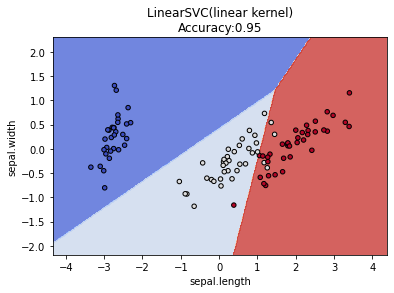

In [12]:
from sklearn import svm

#建立SVM模型
linearSvcModel = svm.LinearSVC(C=1,max_iter=10000)
#使用訓練資料訓練模型
linearSvcModel.fit(train_reduced,y_train)
#使用訓練資料預測分類
predicted = linearSvcModel.predict(train_reduced)

accuracy = linearSvcModel.score(train_reduced,y_train)

X0 , X1 = train_reduced[:,0],train_reduced[:,1]
xx,yy = make_meshgrid(X0,X1)
plot_contours(plt , linearSvcModel,xx,yy,
                cmap=plt.cm.coolwarm , alpha=0.8)
plt.scatter(X0,X1,c=y_train,cmap=plt.cm.coolwarm,s=20,edgecolors="k")
plt.xlabel("sepal.length")
plt.ylabel("sepal.width")
plt.title("LinearSVC(linear kernel)" + "\n" + "Accuracy:%.2f"%accuracy)

### kernel = "linear"

Parameters:
1. C: 限制模型的複雜度，防止過度擬合
2. kernel: 此範例採用線性

Text(0.5, 1.0, 'SVC with linear kernel\nAccuracy:0.96')

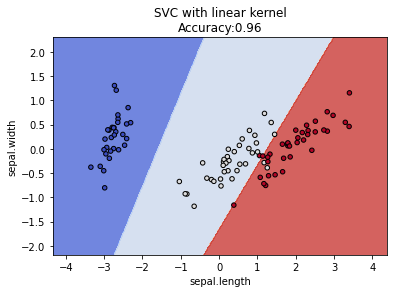

In [13]:
from sklearn import svm

#建立SVM模型
svcModel = svm.SVC(C=1,kernel="linear")
#使用訓練資料訓練模型
svcModel.fit(train_reduced,y_train)

accuracy = svcModel.score(train_reduced,y_train)

X0 , X1 = train_reduced[:,0],train_reduced[:,1]
xx,yy = make_meshgrid(X0,X1)
plot_contours(plt , svcModel,xx,yy,
                cmap=plt.cm.coolwarm , alpha=0.8)
plt.scatter(X0,X1,c=y_train,cmap=plt.cm.coolwarm,s=20,edgecolors="k")
plt.xlabel("sepal.length")
plt.ylabel("sepal.width")
plt.title("SVC with linear kernel" + "\n" + "Accuracy:%.2f"%accuracy)

### kernel = "poly"
Parameters:
1. C: 限制模型的擬合度，防止過度擬合
2. kernel : 此範例採用Polynomial高次方轉換
3. degree : 增加模型複雜度，3代表轉換到三次空間進行分類
4. gamma : 數值越大越能做複雜的分類邊界

Text(0.5, 1.0, 'SVC with polynomial (degree 3) kernel\nAccuracy:0.95')

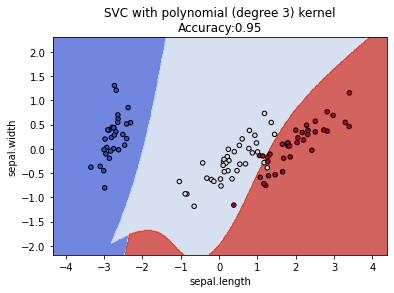

In [14]:
from sklearn import svm

polyModel = svm.SVC(C=1,kernel="poly",degree =3 , gamma="auto")
#使用訓練資料訓練模型
polyModel.fit(train_reduced,y_train)

accuracy = polyModel.score(train_reduced,y_train)

X0 , X1 = train_reduced[:,0],train_reduced[:,1]
xx,yy = make_meshgrid(X0,X1)
plot_contours(plt , polyModel,xx,yy,
                cmap=plt.cm.coolwarm , alpha=0.8)
plt.scatter(X0,X1,c=y_train,cmap=plt.cm.coolwarm,s=20,edgecolors="k")
plt.xlabel("sepal.length")
plt.ylabel("sepal.width")
plt.title("SVC with polynomial (degree 3) kernel" + "\n" + "Accuracy:%.2f"%accuracy)

### kernel = "rbf"

Parameters:
1. C: 限制模型的擬合度，防止過度擬合
2. kernel : 此範例採用RBF (Radial Basis Function)高斯轉換
3. gamma : 數值越大越能做複雜的分類邊界

accuracy :  0.9523809523809523


Text(0.5, 1.0, 'SVC with rbf kernel\nAccuracy:0.95')

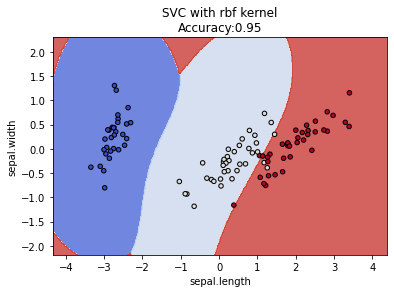

In [16]:
from sklearn import svm

rbfModel = svm.SVC(C=1,kernel="rbf" , gamma=0.7)
#使用訓練資料訓練模型
rbfModel.fit(train_reduced,y_train)

accuracy = rbfModel.score(train_reduced,y_train)
print("accuracy : ",accuracy)

X0 , X1 = train_reduced[:,0],train_reduced[:,1]
xx,yy = make_meshgrid(X0,X1)
plot_contours(plt , rbfModel,xx,yy,
                cmap=plt.cm.coolwarm , alpha=0.8)
plt.scatter(X0,X1,c=y_train,cmap=plt.cm.coolwarm,s=20,edgecolors="k")
plt.xlabel("sepal.length")
plt.ylabel("sepal.width")
plt.title("SVC with rbf kernel" + "\n" + "Accuracy:%.2f"%accuracy)